In [2]:
import pandas as pd
import numpy as np
import gensim
from konlpy.tag import Okt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
import re
import ast
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from tqdm import tqdm
import time

In [3]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\cg063\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [41]:
train = pd.read_json('./origin_data_modify/train_mod3.json', typ='frame')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109282 entries, 0 to 109281
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   tags                         109282 non-null  object
 1   id                           109282 non-null  int64 
 2   plylst_title                 109282 non-null  object
 3   songs                        109282 non-null  object
 4   like_cnt                     109282 non-null  int64 
 5   updt_date                    109282 non-null  object
 6   mapping_plylst_cnt           109282 non-null  int64 
 7   mapping_plylst_cnt_category  109282 non-null  object
 8   song_cnt                     109282 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 8.3+ MB


### 1. 필요한 컬럼만 남기기 & 태그 특수문자 제거

In [42]:
# 필요한 컬럼만 남기기
train = train.iloc[:, :6]
train

,tags,id,plylst_title,songs,like_cnt,updt_date
0,['Pop'],123815,1 1 환상의 케미스트리 211,"[243181, 520307, 291514, 496987, 285795, 68548...",0,2019-03-27 15:27:43.000
1,['팝'],114252,1 HITS OF DECADE SPECIAL,"[527878, 344149, 156954, 492893, 33166, 218207...",1,2013-10-12 20:53:50.000
2,['팝'],50564,1 HITS OF DECADE SPECIAL 2,"[60025, 326802, 82991, 533287, 404318, 82686, ...",5,2009-07-11 21:37:42.000
3,['Pop'],62278,100% 로맨틱 조지 마이클 223,"[366485, 435804, 442680, 538949, 263360, 29495...",0,2019-03-27 15:27:44.000
4,"['기분좋은', '100번']",148495,100번 들어도 기분좋은 가요,"[208186, 155952, 669617, 438439, 397412, 60398...",4,2016-10-31 13:59:41.000
...,...,...,...,...,...,...
109277,['일렉'],56144,00 Party 일렉트로댄스,"[256418, 183424, 431998, 654442, 354592, 24132...",7,2018-02-06 16:02:42.000
109278,['일렉'],58768,00 Electronica__EDM,"[673003, 251403, 617690, 441958, 436128, 62788...",5,2020-01-05 00:24:22.000
109279,['일렉'],110536,0 일렉듣고 광질준비 O K _ElecVVIP,"[349306, 93890, 651902, 46845, 362347, 330768,...",173,2012-11-29 14:34:56.000
109280,"['비오는날', '추억', '회상']",106660,비오는날 듣기 좋은 연주곡 모음,"[79329, 51922, 173875, 216115, 422584, 509605,...",6,2015-10-06 11:45:24.000


In [43]:
# train['tags]를 str -> 리스트로 변환하기

train['tags'] = train['tags'].apply(lambda x: ast.literal_eval(x))
type(train['tags'][0])

list

In [44]:
# 특수문자 '_'가 있는 행 찾기
# '_'가 있는 행 찾기
rows_with_underscore = train['tags'][train['tags'].apply(lambda x: any('_' in tag for tag in x))]
rows_with_underscore

200                           [그래미, Grammy, Kendrick_Lamar]
267       [휴식, 소나기, 흐리고_비, 생각_사색_명상, 센치한_우울한, 부드러운_잔잔한, ...
303               [힙합, weeflow, HipHop, kxan, 힙_합, hiphopb]
304               [힙합, weeflow, HipHop, kxan, 힙_합, hiphopb]
658                                         [기분_전환, 신의_목소리]
                                ...                        
109170    [비오는날, 밤, 새벽, 직접찾은플레이리스트, midnight, 몽환, Pop, h...
109212               [담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]
109232                      [음악, 잔잔한, 새벽, 몽환, 새벽_밤, 감성, 인디]
109233    [카페음악, 신나는_음악, dance, 즐거운_음악, 댄스_음악, 드라이브, 힐링,...
109237    [카페_음악, 밤, space, UNIVERSE, 새벽, 우주, 방안, 조용한음악,...
Name: tags, Length: 2153, dtype: object

In [45]:
# 특수 문자를 제거하는 함수 정의
def remove_special_characters(tag_list):
    cleaned_tags = []
    for tag in tag_list:
        cleaned_tag = re.sub(r'[^\uAC00-\uD7A30-9a-zA-Z\s]', '', tag).replace(" ", "")
        cleaned_tags.append(cleaned_tag)
    return cleaned_tags

In [46]:
# 함수 적용
train['tags'] = train['tags'].apply(remove_special_characters)

In [47]:
# 알맞게 제거 되었는지 확인
train.iloc[[200, 267, 303], :]

,tags,id,plylst_title,songs,like_cnt,updt_date
200,"[그래미, Grammy, KendrickLamar]",118371,Kendrick Lamar와 논란의 Grammy,"[158000, 166761, 655888, 539180, 606851, 15869...",14,2016-02-23 17:02:02.000
267,"[휴식, 소나기, 흐리고비, 생각사색명상, 센치한우울한, 부드러운잔잔한, 비또는눈]",99454,Rainy day,"[219025, 476707, 371788, 35117, 216955, 98472,...",0,2020-04-20 03:00:46.000
303,"[힙합, weeflow, HipHop, kxan, 힙합, hiphopb]",99473,Wee the fuxxing flow Vol 2,"[347310, 184460, 111628, 520738, 567069, 31478...",18,2020-03-25 14:01:14.000


In [48]:
train.to_json('./origin_data_modify/train_mod4.json')

### 2. 군집화

In [4]:
train = pd.read_json('./origin_data_modify/train_mod4.json', typ='frame')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109282 entries, 0 to 109281
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          109282 non-null  object
 1   id            109282 non-null  int64 
 2   plylst_title  109282 non-null  object
 3   songs         109282 non-null  object
 4   like_cnt      109282 non-null  int64 
 5   updt_date     109282 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.8+ MB


In [5]:
train.head()

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[Pop],123815,1 1 환상의 케미스트리 211,"[243181, 520307, 291514, 496987, 285795, 68548...",0,2019-03-27 15:27:43.000
1,[팝],114252,1 HITS OF DECADE SPECIAL,"[527878, 344149, 156954, 492893, 33166, 218207...",1,2013-10-12 20:53:50.000
2,[팝],50564,1 HITS OF DECADE SPECIAL 2,"[60025, 326802, 82991, 533287, 404318, 82686, ...",5,2009-07-11 21:37:42.000
3,[Pop],62278,100% 로맨틱 조지 마이클 223,"[366485, 435804, 442680, 538949, 263360, 29495...",0,2019-03-27 15:27:44.000
4,"[기분좋은, 100번]",148495,100번 들어도 기분좋은 가요,"[208186, 155952, 669617, 438439, 397412, 60398...",4,2016-10-31 13:59:41.000


In [6]:
train['tags'][11219] # 11215 11219

['트렌디', '매장음악', '카페', '감각적인', '리드미컬한', '그루브', '랩노래', '기분전환', '유니크', '빈티지']

- stemming

In [150]:
# words = train['tags'][11219]

# stemmer = PorterStemmer()
# okt = Okt()

# for word in words:
# 	print(okt.nouns(word))

['트렌디']
['매장', '음악']
['카페']
['감각']
[]
['그루', '브']
['랩', '노래']
['기분', '전환']
['유니크']
['빈티']


In [7]:
# train['tags'] unset 진행
tags_list = train.explode('tags')['tags'].values.tolist()
len(tags_list)

457923

In [8]:
# 유니크 태그만 남기기
unique_tag = list(set(tags_list))
len(unique_tag) # 28631개

28631

In [9]:
unique_tag

['',
 'Day',
 'LiveNationKorea',
 '소리바다어워드',
 '발라드3',
 'LuiPeng',
 '프라하',
 '도깨비OST',
 '여유롭게듣기좋은음악',
 '난알아요',
 '부킹',
 '야경',
 'freddiemercury',
 '가슴이',
 '빨래를',
 '의학드라마',
 '울적한마음',
 '엄선함',
 '잔잔하면서',
 '목소리갑',
 '나만의시간',
 '매시브디토',
 '가을밤에어울리는노래',
 '가곡',
 '청량미뿜뿜',
 'AnnieLennox',
 '예쁜누나',
 '부탁',
 'yellow',
 '블루스음악',
 '먹자',
 '목소리',
 '주말엔EDM',
 '댄스모음',
 '감석적인음악',
 '크리스티나노벨리',
 '혼자있고싶을때',
 '가정의달',
 '적적',
 '180114',
 '못하는',
 '디저트송',
 '아마데우스4중주단',
 '씨스타',
 '잠에빠져든다',
 '프로여행러',
 '스펙트럼2018',
 '제목이문장이라니',
 'EDM페스티벌',
 '11월1주차',
 '가게저장용',
 '나의상대는없다',
 '힐러리한',
 '첩보',
 '영원한마왕',
 '노란',
 '2월4주차',
 'PLAY',
 '안정감',
 '퇴근할때',
 '전자맨',
 '메탈리카',
 '느낌적느낌',
 '올해나온곡',
 '팬임',
 '온더로드',
 '하이브리드',
 '고양이',
 '느낌있는pop',
 'smp',
 '대표적인',
 '퓨전록',
 '스윙',
 '일기쓰면서듣기좋은노래',
 '미구엘믹스',
 '60년대',
 '시애틀록',
 '소개합니다',
 '좋은',
 '집가는길',
 '이별이야기',
 '데이빗보위',
 '야갤',
 '심오한',
 '박일남',
 '자유로운',
 '세련된팝송',
 'ForLife',
 '연도별',
 '나폴리민요',
 '18번곡',
 '리메이크가요',
 '스트릿매장',
 '둠짓둠짓',
 '게임브금',
 'JoeyBadass',
 '쎈',
 '월드비트',
 '또듣고싶은',
 '시그널',
 '존헨드릭스',
 'DJ유훼',


- 유사한 단어들끼리 군집화 후 군집 별 lable 달아주기

In [10]:
okt = Okt()

tagged_data = [] # 89개의 TaggedDocument
for i in range(len(unique_tag)) :
  tagged_document = TaggedDocument(words=unique_tag[i], tags=[str(unique_tag[i])])
  tagged_data.append(tagged_document)

len(tagged_data)

28631

In [11]:
sorted_word_list = sorted(unique_tag, key=len, reverse=True)
sorted_word_list

['외모와연주실력모두갖춘클래식아티스트',
 'BillboardDecember',
 '유어어어아아아어어어어어엉우아아',
 '매장커피숍호텔로비추천인기클래식',
 'BlueBottleCoffee',
 'TheSoundofCHANEL',
 'FuturisticSwaver',
 '카페커피숖호텔라운지에서듣는재즈',
 '커피숍매장라운지자장가추천클래식',
 'socialdistancing',
 '피아노바이올린협주곡관현악클래식',
 '사진작가김경민님의사진출저입니다',
 '5secondsofsummer',
 'ProgressiveHouse',
 '프로듀스101시즌2포지션평가곡',
 'SebastienTellier',
 'LiveNationKorea',
 '믿고들어보는어나니머스아티스트',
 '스트레스해소인기추천힐링클래식',
 'TwentyOnePilots',
 '투모로우바이투게더플레이리스트',
 '휴식시간휴가에들으면좋은클래식',
 'markdeclivelowe',
 'MichaelKiwanuka',
 '나혼자들을플레이리스트입니다후',
 'KathleenFerrier',
 'LuvJonesRecords',
 '스트레스해소힐링추천인기클래식',
 'DharmaWorldwide',
 '엄청긴태그도있어요오오오발라드',
 '누군가생각나는것만같은갬성힙합',
 'URBANPLAYGROUND',
 '매장커피숖호텔라운지추천클래식',
 'MERRYCHRHISTMAS',
 '인기추천스트레스해소힐링클래식',
 'ArianaGrandeari',
 '망할게뻔한모험을부추기는노래들',
 'BJtheChicagoKid',
 'CigarettesAfter',
 'LeagueofLegends',
 'CarrieUnderwood',
 '하이네켄프레젠트스타디움입니다',
 '매장커피숍호텔라운지추천클래식',
 '힘든데기댈사람이없을때듣는노래',
 '욕하고싶지만교양또한지키고싶다',
 'HotelCalifornia',
 'TheChainsmokers',
 'BlackMusicChild',
 '책읽을때적당히틀어놓기좋은음악',
 

In [12]:
len(sorted_word_list[0])

18

In [13]:
# Doc2Vec 적용(문서 -> 숫자)
# dm=0 => DBOW 알고리즘 사용(단어 순서 고려 X)
# epochs => 같은 데이터에 대해 3번 학습을 반복

model = Doc2Vec(vector_size=20, dm=0, epochs=40)
model.build_vocab(tagged_data)

In [14]:
model.corpus_count

28631

In [15]:
# train 사용
model.train(corpus_iterable=tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

- Doc2Vec의 결과 확인

In [16]:
model.dv.most_similar('kpop')

[('kpip', 0.9818162322044373),
 ('kpo', 0.9814845323562622),
 ('ukpop', 0.9768790602684021),
 ('postpunk', 0.9728212952613831),
 ('korerap', 0.9719709157943726),
 ('punk', 0.9700957536697388),
 ('koreahiphop', 0.9693085551261902),
 ('kokobop', 0.9667014479637146),
 ('punkrock', 0.9593318700790405),
 ('popchart', 0.9579322934150696)]

In [17]:
model.dv.most_similar('크리스마스')

[('크리스마스테마', 0.9756664633750916),
 ('메리크리마스', 0.9707426428794861),
 ('마리슈', 0.9661348462104797),
 ('메리크리스마스', 0.9657930135726929),
 ('마스크', 0.9597482681274414),
 ('스크랴빈', 0.9560109972953796),
 ('라스트크리스마스', 0.9555896520614624),
 ('마크툽', 0.9502997398376465),
 ('마리스얀손스', 0.9456478357315063),
 ('크리스탈', 0.9426530003547668)]

In [18]:
model.dv.most_similar('캐롤')

[('캐럴', 0.9614615440368652),
 ('캐롤킹', 0.9528294801712036),
 ('캐럿', 0.9447311758995056),
 ('캐논', 0.9293859004974365),
 ('롤', 0.9126745462417603),
 ('old캐롤', 0.9126570224761963),
 ('캐롤송', 0.9081723690032959),
 ('케롤', 0.8926147222518921),
 ('팝캐롤', 0.8899141550064087),
 ('샤캐', 0.889596164226532)]

In [19]:
model.dv.most_similar('여행')

[('여행자', 0.9646961092948914),
 ('가족여행', 0.9622893929481506),
 ('여행가자', 0.956249475479126),
 ('여긴', 0.9493026733398438),
 ('여름여행', 0.9489668011665344),
 ('여왕', 0.944286584854126),
 ('참여', 0.9429938197135925),
 ('여행길', 0.9412221908569336),
 ('여행가기', 0.9406920671463013),
 ('잉여', 0.9394342303276062)]

In [20]:
model.dv.most_similar('Pop')

[('Poppop', 0.9797617793083191),
 ('PopRap', 0.9777047038078308),
 ('SoulPop', 0.9721333384513855),
 ('Popular', 0.9602019786834717),
 ('Purple', 0.9574604630470276),
 ('SophistiPop', 0.9565920233726501),
 ('LilPump', 0.9543551206588745),
 ('SynthPop', 0.9494490027427673),
 ('PostBop', 0.9478663802146912),
 ('OpenArms', 0.9438180327415466)]

In [21]:
model.dv.most_similar('발라드')

[('발라', 0.9861674308776855),
 ('발라드및', 0.9849256277084351),
 ('롹발라드', 0.982241690158844),
 ('랩발라드', 0.9754948019981384),
 ('갓발라드', 0.9684540033340454),
 ('발라드랩', 0.9639233946800232),
 ('슬픈발라드', 0.9444116950035095),
 ('발라드락', 0.9408860206604004),
 ('팀발랜드', 0.9353188872337341),
 ('이별발라드', 0.9345559477806091)]

In [22]:
model.dv.vectors.shape

(28631, 20)

In [23]:
model.dv.vectors

array([[-0.02615408, -0.02989563, -0.04940377, ...,  0.04612811,
        -0.04750933, -0.01729043],
       [-0.18529254, -0.23071551,  0.02314721, ...,  0.00453972,
         0.34861112, -0.24738824],
       [-0.15618044, -0.530739  ,  0.3117756 , ...,  0.15450522,
         0.31676263, -0.14443725],
       ...,
       [-0.61099106,  0.13552162,  0.20773537, ..., -0.5379396 ,
         0.06149905,  0.07318252],
       [-0.32419747, -0.01807838,  0.19296211, ...,  0.1944363 ,
         0.40845525,  0.34145662],
       [-0.3265646 ,  0.14195219,  0.04120928, ..., -0.00143328,
         0.115568  ,  0.16672024]], dtype=float32)

In [24]:
doc_representations = model.dv.vectors
doc_representations.shape

(28631, 20)

In [25]:
df_new = pd.DataFrame()
df_new['tag_name'] = model.dv.index_to_key # 영화마다 군집화하게되면 군집별로 번호가 붙인다
df_new.head()

,tag_name
0,
1,Day
2,LiveNationKorea
3,소리바다어워드
4,발라드3


- 군집화

In [26]:
# k-means 군집화 알고리즘을 사용해 클러스터 개수를 조절하면서 왜곡을 계산

distortions = [] # 왜곡값을 저장할 빈 리스트 생성

for k in tqdm(range(1, 100), desc="K-Means Clustering Progress"):  # range 범위 내의 k에 대해 반복
    kmeans = KMeans(n_clusters=k, n_init=10)  # n_init 초기화 횟수
    kmeans.fit(doc_representations)  # 비지도 학습 수행
    distortions.append(kmeans.inertia_)

K-Means Clustering Progress: 100%|██████████| 99/99 [10:41<00:00,  6.48s/it]


In [27]:
distortions

[21573.091796875,
 18597.3046875,
 17258.44921875,
 16475.37109375,
 15804.650390625,
 15317.177734375,
 14939.185546875,
 14614.52734375,
 14373.5302734375,
 14168.0615234375,
 13978.77734375,
 13796.6865234375,
 13644.92578125,
 13494.92578125,
 13347.7734375,
 13218.685546875,
 13090.828125,
 12967.98046875,
 12864.474609375,
 12790.3955078125,
 12660.7080078125,
 12596.326171875,
 12537.123046875,
 12441.736328125,
 12372.2578125,
 12259.0927734375,
 12191.2568359375,
 12139.93359375,
 12028.2998046875,
 11965.28125,
 11923.6044921875,
 11834.48828125,
 11795.0703125,
 11741.064453125,
 11694.5009765625,
 11638.0810546875,
 11580.474609375,
 11514.8330078125,
 11456.8271484375,
 11424.2275390625,
 11366.763671875,
 11345.3154296875,
 11293.9140625,
 11262.287109375,
 11208.728515625,
 11159.4013671875,
 11125.7685546875,
 11080.654296875,
 11059.146484375,
 11026.5439453125,
 10988.1259765625,
 10938.6904296875,
 10908.8603515625,
 10881.396484375,
 10827.25,
 10825.369140625,
 107

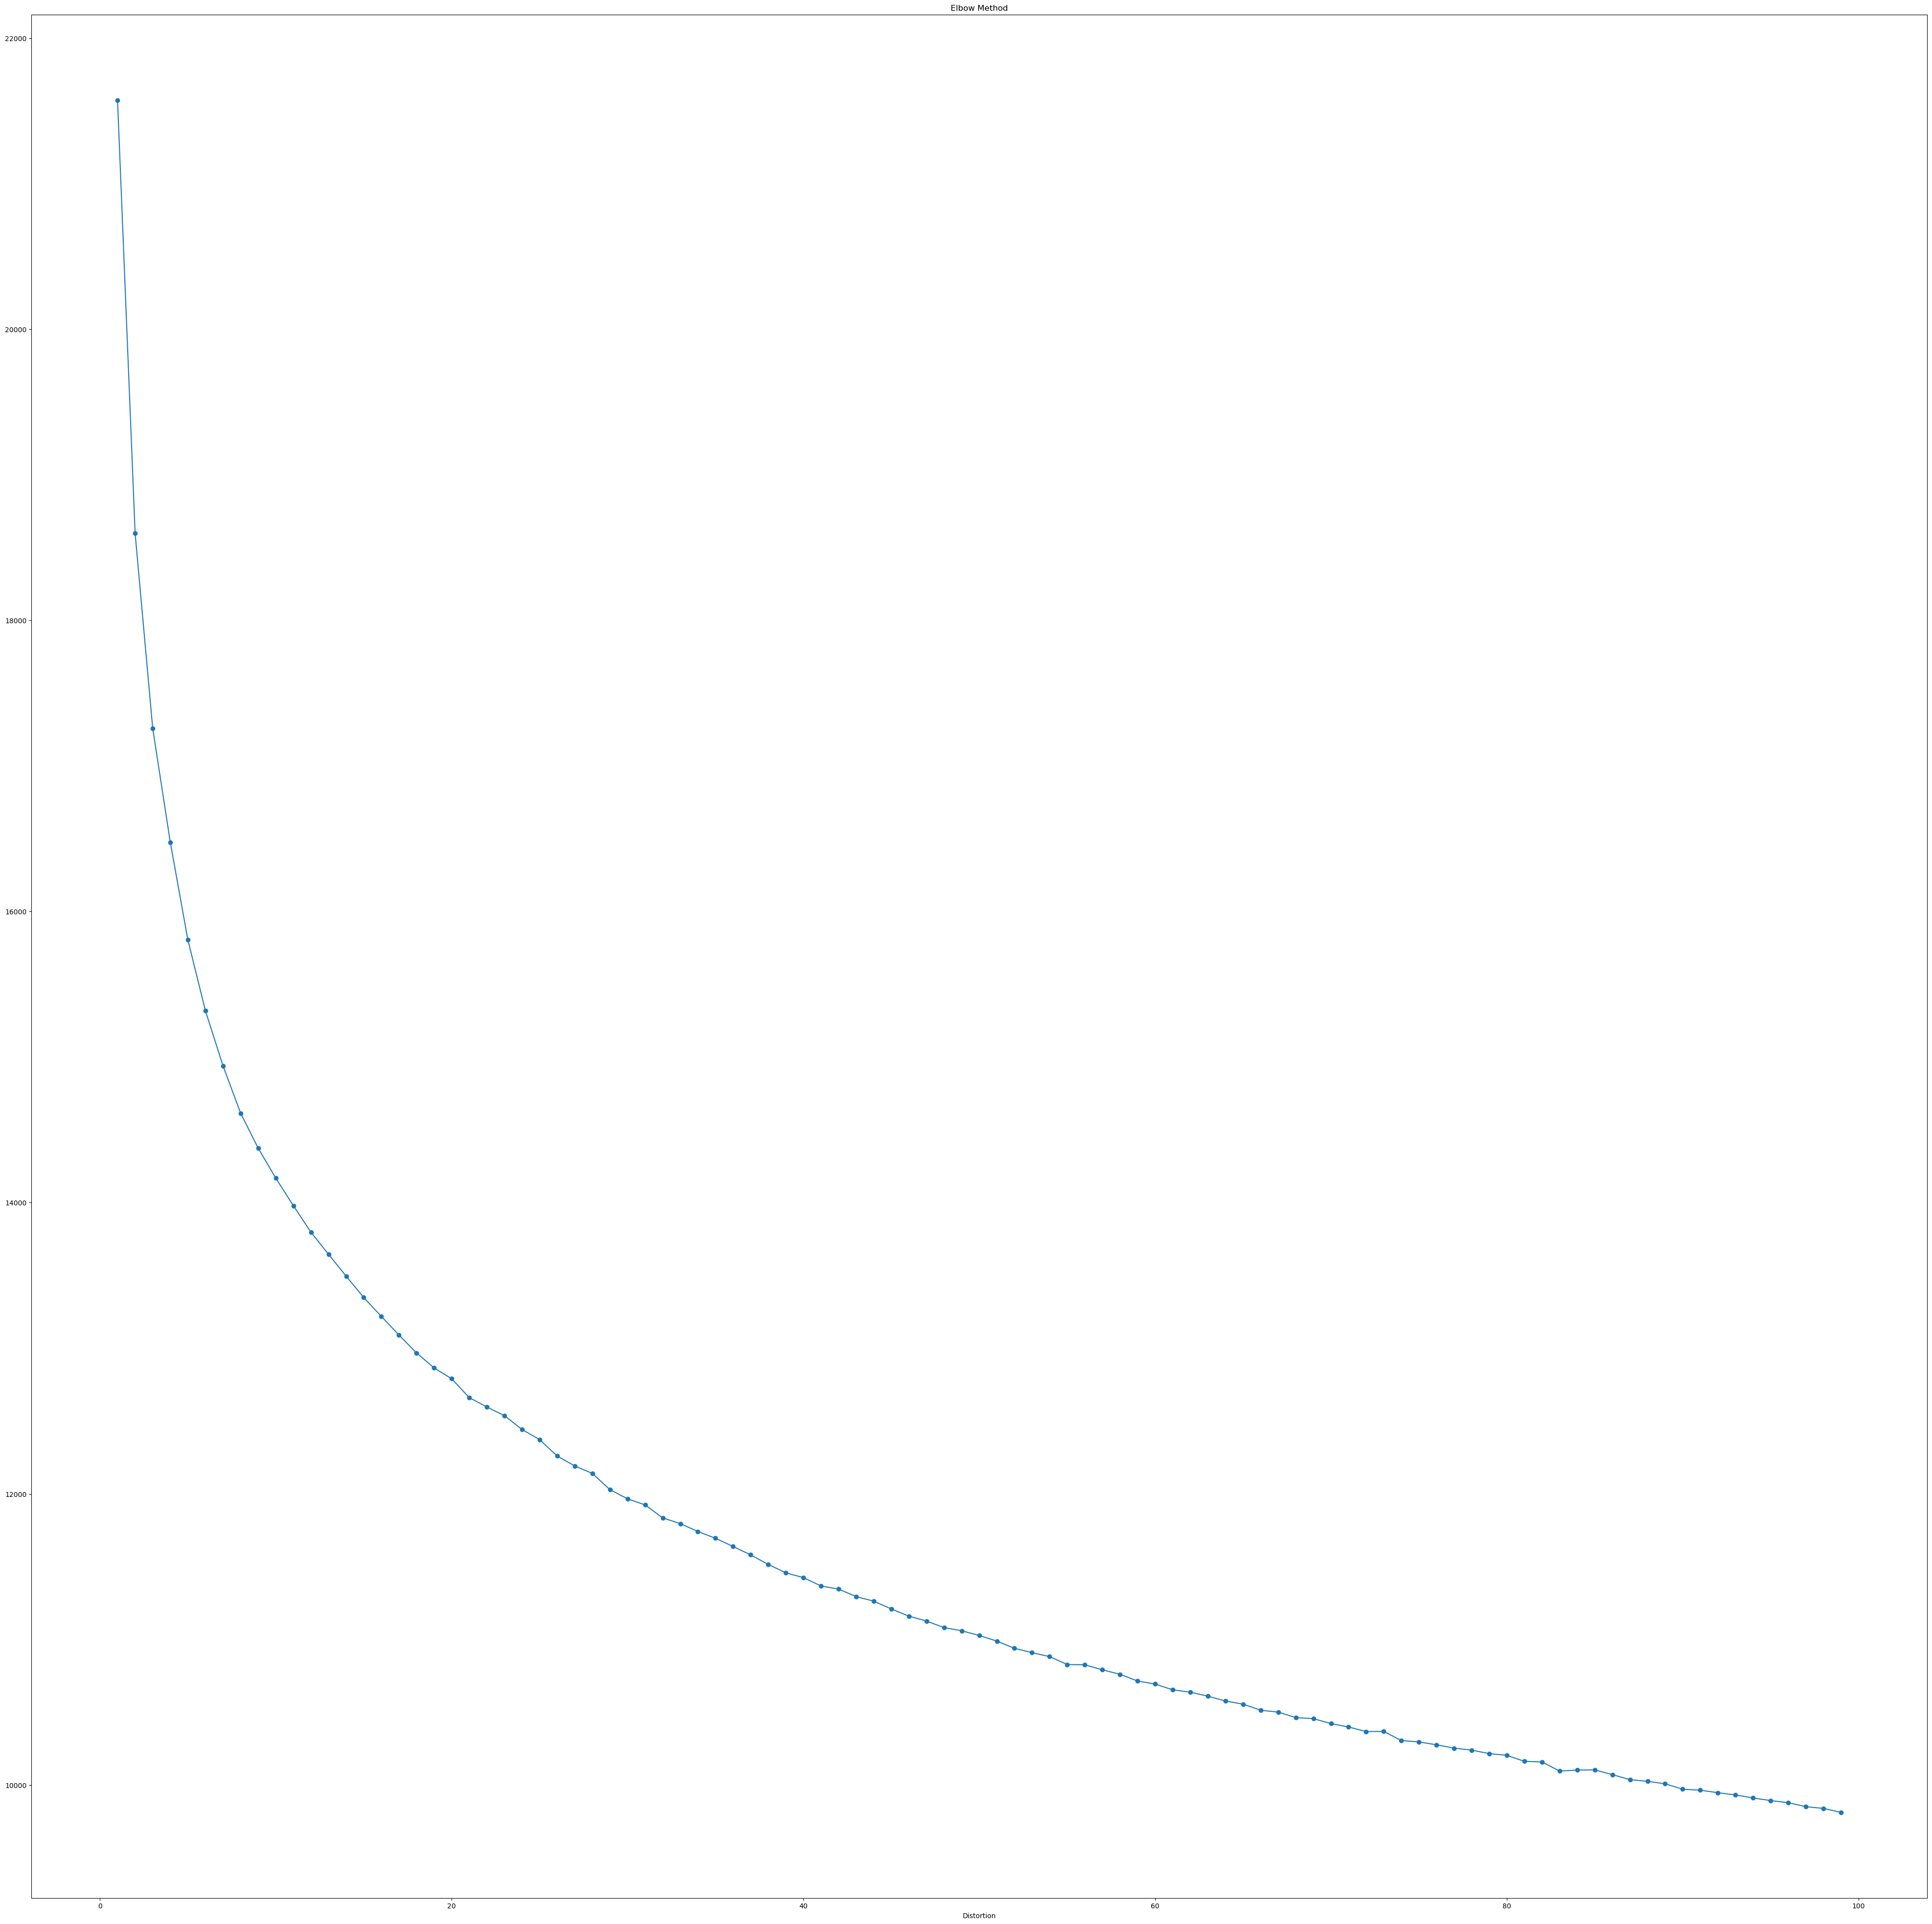

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))
plt.plot(range(1, 100), distortions, 'o-')
plt.xlabel('k')
plt.xlabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [29]:
selected_k=100
kmeans = KMeans(n_clusters=selected_k, n_init=10)
kmeans.fit(doc_representations)
kmeans.labels_

array([12, 41, 41, ..., 43, 88,  2])

In [31]:
df_new['그룹'] = kmeans.labels_
df_new['그룹'].value_counts()

12    1331
10     666
18     463
71     454
29     445
      ... 
95     151
6      146
34     113
44     113
84      97
Name: 그룹, Length: 100, dtype: int64

In [34]:
df_new.loc[df_new['그룹'] == 50, :]

,tag_name,그룹
17,엄선함,50
138,할렐루야,50
237,신형원,50
270,선선한저녁,50
454,흥함,50
...,...,...
27820,이선규,50
27895,벡야,50
27917,패신저,50
27960,배신,50
